In [22]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")

result=llm.invoke("HEllo!")
result


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 39, 'total_tokens': 49, 'completion_time': 0.011397953, 'prompt_time': 0.002249477, 'queue_time': 0.049738833, 'total_time': 0.01364743}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_90c2e79dab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--44d113bc-f66b-4f4c-afe5-68e924c5b46e-0', usage_metadata={'input_tokens': 39, 'output_tokens': 10, 'total_tokens': 49})

In [23]:
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The next step in the routing process")


##Augement the LLm with schema 
router=llm.with_structured_output(Route)

class State(TypedDict):
    input:str
    decision:str
    output:str

def llm_call_1(state:State):
    """Write a story"""

    result=llm.invoke(state["input"])
    return{"output":result.content}


def llm_call_2(state:State):
    """Write a joke"""
    
    result=llm.invoke(state["input"])
    return{"output":result.content}

def llm_call_3(state:State):
    """Write a poem"""
    
    result=llm.invoke(state["input"])
    return{"output":result.content}

def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    decision= router.invoke(
        [
            SystemMessage(
                content="Route the input to story,joke or poem baaed on the users request "
            ),
            HumanMessage(content=state["input"])
        ]
    ) 
    return{"decision":decision.step}

In [24]:
def route_decision(state:State):

    if state["decision"] =="story":
        return "llm_call_1"
    elif state["decision"] =="joke":
        return "llm_call_2"
    elif state["decision"] =="poem":
        return "llm_call_3"

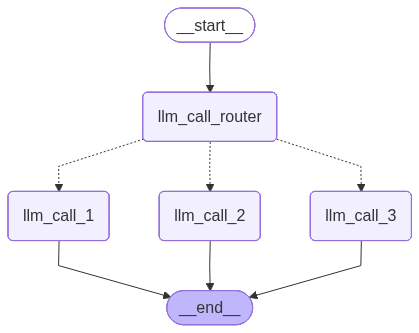

In [25]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

router_buillder= StateGraph(State)

router_buillder.add_node("llm_call_1",llm_call_1)
router_buillder.add_node("llm_call_2",llm_call_2)
router_buillder.add_node("llm_call_3",llm_call_3)
router_buillder.add_node("llm_call_router",llm_call_router)

router_buillder.add_edge(START,"llm_call_router")
router_buillder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1":"llm_call_1",
        "llm_call_2":"llm_call_2",
        "llm_call_3":"llm_call_3",

    },
)
router_buillder.add_edge("llm_call_1",END)
router_buillder.add_edge("llm_call_2",END)
router_buillder.add_edge("llm_call_3",END)

router_workflow= router_buillder.compile()
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [35]:
state=router_workflow.invoke({"input":"Write me a poem with related to time that is cold cinematic , shoes the struggle of huamans with reapect to it"})
state


{'input': 'Write me a poem with related to time that is cold cinematic , shoes the struggle of huamans with reapect to it',
 'decision': 'poem',
 'output': '**"Echoes of Eternity"**\n\nIn the vast expanse of time\'s dark stage,\nA lone figure stands, a fleeting page,\nA moment\'s pause, a heartbeat\'s span,\nA life unwinds, like sand in an hourglass pan.\n\nThe clock ticks on, a metronome\'s beat,\nA relentless march, a soul\'s defeated repeat,\nA dance with fate, a waltz with despair,\nA struggle to keep pace, to hold on to a snare.\n\nThe hands of time, like grasping fingers, cold,\nReach out to snatch, to claim the stories untold,\nA fleeting thought, a whispered sigh,\nA moment\'s beauty, lost in the passing sky.\n\nWe chase the hours, like autumn leaves,\nA fragile grasp, a desperate release,\nWe cling to memories, like a lifeline\'s thread,\nA fragile hold, a moment\'s dread.\n\nIn the mirror\'s gaze, a reflection stares,\nA stranger\'s face, with lines and wrinkles, worn and sha

In [36]:
print(state["input"])

Write me a poem with related to time that is cold cinematic , shoes the struggle of huamans with reapect to it


In [37]:
print(state["output"])

**"Echoes of Eternity"**

In the vast expanse of time's dark stage,
A lone figure stands, a fleeting page,
A moment's pause, a heartbeat's span,
A life unwinds, like sand in an hourglass pan.

The clock ticks on, a metronome's beat,
A relentless march, a soul's defeated repeat,
A dance with fate, a waltz with despair,
A struggle to keep pace, to hold on to a snare.

The hands of time, like grasping fingers, cold,
Reach out to snatch, to claim the stories untold,
A fleeting thought, a whispered sigh,
A moment's beauty, lost in the passing sky.

We chase the hours, like autumn leaves,
A fragile grasp, a desperate release,
We cling to memories, like a lifeline's thread,
A fragile hold, a moment's dread.

In the mirror's gaze, a reflection stares,
A stranger's face, with lines and wrinkles, worn and shared,
A life lived, like a book, with pages turned,
A story told, in moments, like a burning concern.

The wind howls on, like a mournful sigh,
A lonely whisper, that echoes through the sky,
